## PySpark Tools

# Customer Churn Prediction Model

* The goal of a customer churn model is to evaluate the behaviors and attributes of current and former customers to determine trends that lead to churn.
* Several behavioral factors that are widely used in these models are customer purchase intervals, cancellations, follow-up calls, emails, and on-page engagement. Customer attributes, like demographics, location, and income, can also be indicators of churn likelihood.

* Customer churn models are generally created with a classification algorithm, like logistic regression or decision trees. For these algorithms, all categorical data must be converted into a numerical equivalent using techniques like one-hot-encoding.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Window

# import pyspark analytic functions
from pyspark.sql.functions import avg, col, concat, count, desc, isnull, \
asc, explode, lit, min, max, split, stddev, udf, isnan, when, rank, \
log, sqrt, cbrt, exp, count, isnan, countDistinct
from sklearn.preprocessing import LabelEncoder 


In [41]:
# import pyspark analytic functions
from pyspark.sql import functions as F, window
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import min as Fmin, max as Fmax, sum as Fsum, round as Fround
from pyspark.sql.types import IntegerType, DateType, TimestampType, StringType


In [3]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()


22/11/05 14:27:29 WARN Utils: Your hostname, Andrews-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.39 instead (on interface en0)
22/11/05 14:27:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/05 14:27:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/11/05 14:27:31 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/11/05 14:27:31 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 



In [4]:
# load data
path = "data/mini_sparkify_event_data.json"
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = spark.read.json(path)
df.createOrReplaceTempView("df")
df.take(1)


[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

## Examine Dataframe Schema
* show dataframe columns names & datatype


In [5]:
# print schema
df.printSchema()


root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



## Examine Elements of Dataframe


### Examine Elements by Column


In [6]:
# show first rows
df.select('artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', \
          'length', 'level', 'location', 'method').show(5)


+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|
|    Adam Lambert|Logged In|    Colin|     M|           51| Freeman| 282.8273| paid|     Bakersfield, CA|   PUT|
|          Enigma|Logged In|    Micah|     M|           80|    Long|262.71302| free|Boston-Cambridge-...|   PUT|
|       Daft Punk|Logged In|    Colin|     M|           52| Freeman|223.60771| paid|     Bakersfield, CA|   PUT|
+----------------+---------+---------+------+-------------+--------+---------+-----+------------

In [7]:
# show first rows
df.select('page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', \
          'userId').show(5)


+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|NextSong|1538331630000|        8|              Canada|   200|1538352180000|"Mozilla/5.0 (Win...|     9|
|NextSong|1538173362000|       29|   Time For Miracles|   200|1538352394000|Mozilla/5.0 (Wind...|    30|
|NextSong|1538331630000|        8|Knocking On Forbi...|   200|1538352416000|"Mozilla/5.0 (Win...|     9|
|NextSong|1538173362000|       29|Harder Better Fas...|   200|1538352676000|Mozilla/5.0 (Wind...|    30|
+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
only showing top 5 rows



In [8]:
# show first rows
df.select('registration', 'ts').show(5)


+-------------+-------------+
| registration|           ts|
+-------------+-------------+
|1538173362000|1538352117000|
|1538331630000|1538352180000|
|1538173362000|1538352394000|
|1538331630000|1538352416000|
|1538173362000|1538352676000|
+-------------+-------------+
only showing top 5 rows



## Clean Missing & Empty Values

* For string columns, check for None and null
* For numeric columns, check for zeroes and NaN


In [9]:
# Check for missing values
for value in df.columns:
    print ("(",value,") missing values: ", df.where(df[value].isNull()).count())
    

( artist ) missing values:  58392
( auth ) missing values:  0
( firstName ) missing values:  8346
( gender ) missing values:  8346


( itemInSession ) missing values:  0
( lastName ) missing values:  8346
( length ) missing values:  58392
( level ) missing values:  0
( location ) missing values:  8346
( method ) missing values:  0
( page ) missing values:  0
( registration ) missing values:  8346
( sessionId ) missing values:  0
( song ) missing values:  58392
( status ) missing values:  0
( ts ) missing values:  0
( userAgent ) missing values:  8346
( userId ) missing values:  0


In [10]:
# Check for empty values
for value in df.columns:
    print ("(",value,") empty values: ", df.filter(df[value] == '').count())
    

( artist ) empty values:  0
( auth ) empty values:  0
( firstName ) empty values:  0
( gender ) empty values:  0
( itemInSession ) empty values:  0
( lastName ) empty values:  0
( length ) empty values:  0
( level ) empty values:  0
( location ) empty values:  0
( method ) empty values:  0
( page ) empty values:  0
( registration ) empty values:  0
( sessionId ) empty values:  0
( song ) empty values:  0
( status ) empty values:  0
( ts ) empty values:  0
( userAgent ) empty values:  0
( userId ) empty values:  8346


### Remove Columns with Missing userId  or sessionId Entries
* Remove entries with missing userId or sessionId

In [11]:
# Remove records with missing values in userId or sessionId
num_rows = df.count()
print(f"There are {df.count()} rows in the dataset")

df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])
print(f" {num_rows - df.count()} missing values")


There are 286500 rows in the dataset.
 0 missing values in userId or sessionId.


In [12]:
# Remove columns with empty userId
df = df.filter(df.userId != "")


In [45]:
# count records after filter
df.count()


278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Cancellation Event Churn

In [13]:
# define churn cancellation event
churn_cancel = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churn", churn_cancel("page"))


In [14]:
# Percent users who have cancelled/churned
churn_percent = df.groupBy('userId').agg({'churn': 'sum'})\
    .select(avg('sum(churn)')).collect()[0]['avg(sum(churn))']
print(f"{round(churn_percent * 100, 1)}% of users churned.")


23.1% of users churned.


## Exploratory Data Analysis


**Compare user behavior between churn and not churn.**

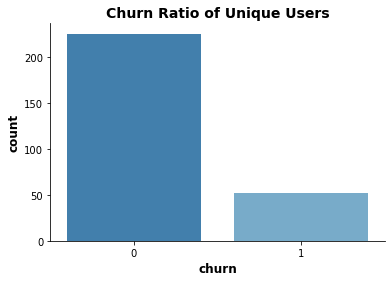

In [34]:
# plot churn ratio for unique users
user_churn = df.dropDuplicates(["userId", "Churn"]).groupby(["Churn"]).count().sort("Churn").toPandas()
ax = sns.barplot(x='Churn', y='count', data=user_churn, palette='tab20c')
plt.title('Churn Ratio of Unique Users', size=14, fontweight = 'bold')
plt.xlabel('churn', fontsize=12, weight='bold')
plt.ylabel('count', fontsize=12, weight='bold')
sns.despine(ax=ax);
plt.savefig('plots/total_churn_ratio.png')


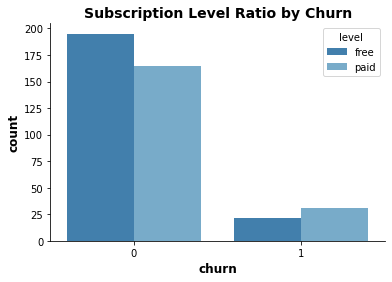

In [33]:
# plot churn ratio for paid and free subscribers 
subscription_churn = df.dropDuplicates(["userId", "level",'Churn']).groupby(["Churn",'level']).count().sort("Churn").toPandas()
ax = sns.barplot(x="Churn", y="count",hue='level', data=subscription_churn, palette='tab20c')
plt.title('Subscription Level Ratio by Churn', size=14, fontweight = 'bold')
plt.xlabel('churn', fontsize=12, weight='bold')
plt.ylabel('count', fontsize=12, weight='bold')
sns.despine(ax=ax);
plt.savefig('plots/subscription_level_churn_ratio')


## Churn by SQL

In [17]:
# create churn_event table
churn_event_log = spark.sql("""
    SELECT
        cc.*,
        FROM_UNIXTIME(registration/1000, "Y-M-d HH:mm:ss") AS registration_time,
        FROM_UNIXTIME(ts/1000, "Y-M-d HH:mm:ss") AS action_time,
        CASE
            WHEN cc.page='Cancellation Confirmation' THEN 1
            ELSE 0
        END AS churn_event
    FROM
        df AS cc
""")

churn_event_log.createOrReplaceTempView("churn_event_log")


In [18]:
# create 'churn' column: 1 if churned, 0 if not.
churn_event_log = spark.sql("""
    SELECT
        artist, auth, gender, itemInSession,
        length, level, location, method, page,
        registration_time, sessionId, song, status,
        userAgent, userId, action_time, churn_event,
        MAX(churn_event) OVER (PARTITION BY userId) AS churn
    FROM
        churn_event_log
""")

churn_event_log.createOrReplaceTempView("churn_event_log")


In [22]:
# select userId that churned
spark.sql("""
    SELECT action_time, page, userId, level, churn_event, churn 
    FROM churn_event_log
    WHERE churn = 1 and churn_event = 1 
    ORDER BY userId, action_time
    LIMIT 10
""").show()

+-------------------+--------------------+------+-----+-----------+-----+
|        action_time|                page|userId|level|churn_event|churn|
+-------------------+--------------------+------+-----+-----------+-----+
| 2018-10-2 09:36:45|Cancellation Conf...|100001| free|          1|    1|
|2018-10-11 09:19:41|Cancellation Conf...|100003| free|          1|    1|
|2018-10-19 10:57:05|Cancellation Conf...|100005| free|          1|    1|
| 2018-10-5 08:24:30|Cancellation Conf...|100006| free|          1|    1|
|2018-11-29 03:45:09|Cancellation Conf...|100007| paid|          1|    1|
|2018-10-26 20:31:44|Cancellation Conf...|100009| free|          1|    1|
| 2018-10-1 11:04:45|Cancellation Conf...|100011| free|          1|    1|
| 2018-11-1 12:35:00|Cancellation Conf...|100012| free|          1|    1|
| 2018-11-2 11:53:36|Cancellation Conf...|100013| paid|          1|    1|
|2018-11-20 11:04:09|Cancellation Conf...|100014| paid|          1|    1|
+-------------------+-----------------

In [23]:
# check churn labeling for userId 100001
spark.sql("""
    SELECT action_time, page, userId, level, churn_event,churn 
    FROM churn_event_log
    WHERE userId = 100001 
    ORDER BY action_time DESC
    LIMIT 10
""").show()


+------------------+--------------------+------+-----+-----------+-----+
|       action_time|                page|userId|level|churn_event|churn|
+------------------+--------------------+------+-----+-----------+-----+
|2018-9-30 23:53:03|         Roll Advert|100001| free|          0|    1|
|2018-9-30 23:52:27|            NextSong|100001| free|          0|    1|
|2018-9-30 23:49:02|         Roll Advert|100001| free|          0|    1|
|2018-9-30 23:48:29|            NextSong|100001| free|          0|    1|
|2018-9-30 23:48:24|                Home|100001| free|          0|    1|
|2018-10-2 09:36:45|Cancellation Conf...|100001| free|          1|    1|
|2018-10-2 09:34:34|              Cancel|100001| free|          0|    1|
|2018-10-2 09:34:33|         Roll Advert|100001| free|          0|    1|
|2018-10-2 09:33:52|            NextSong|100001| free|          0|    1|
|2018-10-2 09:29:46|                Home|100001| free|          0|    1|
+------------------+--------------------+------+---

## User Tenure
* User Tenure is the duration of active service: from registration until cancellation.


In [25]:
# calculate user tenure in days
user_tenure = spark.sql("""
    SELECT userId, 
    INT((UNIX_TIMESTAMP(MAX(action_time)) - UNIX_TIMESTAMP(MIN(registration_time)))/86400) AS tenure_days,
    MAX(churn) AS churn
    FROM churn_event_log
    GROUP BY userId
""")

user_tenure.createOrReplaceTempView("user_tenure")
user_tenure.show(5)



+------+-----------+-----+
|userId|tenure_days|churn|
+------+-----------+-----+
|   100|         43|    0|
|100005|         72|    1|
|100006|          9|    1|
|100007|         93|    1|
|100008|         68|    0|
+------+-----------+-----+
only showing top 5 rows



In [28]:
user_tenure_df = user_tenure.toPandas()
user_tenure_df.head()


,userId,tenure_days,churn
0,100,43.0,0
1,100005,72.0,1
2,100006,9.0,1
3,100007,93.0,1
4,100008,68.0,0


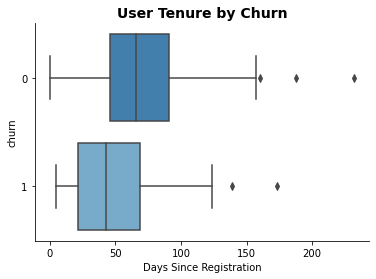

In [32]:
# plot user tenure given churn
ax = sns.boxplot(data=user_tenure_df, y='churn', x='tenure_days', orient='h', palette='tab20c')
plt.xlabel('Days Since Registration')
plt.ylabel('churn')
plt.title('User Tenure  by Churn', size=14, fontweight = 'bold')
sns.despine(ax=ax);
# plt.savefig('plots/user_tenure')


**Users who cancel have shorter tenure.**

## Plot User Engagement
* average events per session
* number songs per session
* playlist adds per session
* session length
* thumbs up/down per session


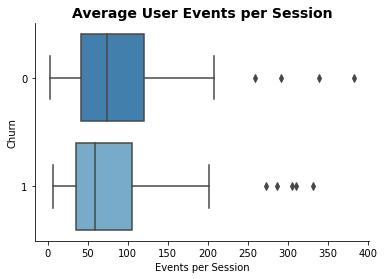

In [38]:
# plot average number of events (items) per session
items = df.select('userId','itemInSession','Churn') \
    .groupBy('userId','Churn') \
    .agg({'itemInSession':'avg'}) \
    .withColumnRenamed('avg(itemInSession)','itemInSession') \
    .select('userId', 'Churn', (col('itemInSession')).alias('itemInSession')) \
    .toPandas()
ax = sns.boxplot(data=items, y='Churn', x='itemInSession', orient='h', palette='tab20c')
plt.title('Average User Events per Session', size=14, fontweight = 'bold')
plt.xlabel('Events per Session')
plt.ylabel('Churn')
sns.despine(ax=ax);
# plt.savefig('plots/avg items per session')

In [39]:
# plot number of songs player per session
# total songs listened to
# unique songs listened to


**How much of a specific action users experience per a certain time unit or number of songs played?**
* how many ads per session length
* how many ads per songs played

## Session Length

/Users/andrewnachtigal/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


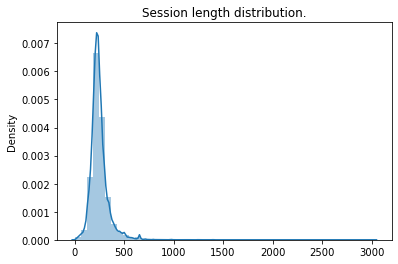

In [51]:
length_session = spark.sql('''
                        SELECT length
                        FROM df
                                                    ''')
sns.distplot(length_session.toPandas().dropna());
plt.title('Session length distribution.');
# plt.savefig('plots/avg items per session')


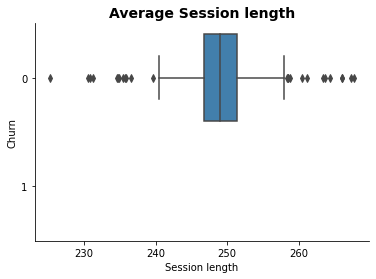

In [50]:
# plot average session length per user
items = df.select('userId','length','Churn') \
    .groupBy('userId','Churn') \
    .agg({'length':'avg'}) \
    .withColumnRenamed('avg(length)','length') \
    .select('userId', 'Churn', (col('length')).alias('length')) \
    .toPandas()
ax = sns.boxplot(data=items, y='Churn', x='length', orient='h', palette='tab20c')
plt.title('Average Session Length by Churn', size=14, fontweight = 'bold')
plt.xlabel('Session l ength')
plt.ylabel('Churn')
sns.despine(ax=ax);
# plt.savefig('plots/avg items per session')


# Page Events


In [46]:
# examine page events
pages = spark.sql("SELECT DISTINCT page FROM df")
page_event = [row['page'] for row in pages.collect()]
page_event


['Cancel',
 'Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'Cancellation Confirmation',
 'About',
 'Settings',
 'Login',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade',
 'Submit Registration',
 'Register']

**Window Function**

In [ ]:
from pyspark.sql import Window
windowSpec = \
  Window \
    .partitionBy(...) \
    .orderBy(...)

In [42]:
# partition dataframe by user
wf_user = window.Window().partitionBy('userId')


In [48]:
wf_user.show()

AttributeError: 'WindowSpec' object has no attribute 'show'

In [44]:
# collect page event data by user
feature_list = df\
.withColumn('f_total_interactions',F.count('*').over(wf_user))\
.withColumn('f_artist_count', F.size(F.collect_set(F.col('artist')).over(wf_user)))\
.withColumn('f_song_count', F.size(F.collect_set(F.col('song')).over(wf_user)))\
.withColumn('f_session_count', F.size(F.collect_set(F.col('sessionId')).over(wf_user)))\
.withColumn('p_homepage_lands', F.sum(F.when(F.col('page')=='Home',1).otherwise(0)).over(wf_user))\
.withColumn('p_nextsongs', F.sum(F.when(F.col('page')=='NextSong',1).otherwise(0)).over(wf_user))\
.withColumn('p_thumbsup', F.sum(F.when(F.col('page')=='Thumbs Up',1).otherwise(0)).over(wf_user))\
.withColumn('p_thumbsdown', F.sum(F.when(F.col('page')=='Thumbs Down',1).otherwise(0)).over(wf_user))\
.withColumn('p_addtoplaylist', F.sum(F.when(F.col('page')=='Add to Playlist',1).otherwise(0)).over(wf_user))\
.withColumn('p_addfriend', F.sum(F.when(F.col('page')=='Add Friend',1).otherwise(0)).over(wf_user))\
.withColumn('p_rolladvert', F.sum(F.when(F.col('page')=='Roll Advert',1).otherwise(0)).over(wf_user))\
.withColumn('p_logout', F.sum(F.when(F.col('page')=='Logout',1).otherwise(0)).over(wf_user))\
.withColumn('p_downgrade', F.sum(F.when(F.col('page')=='Downgrade',1).otherwise(0)).over(wf_user))\
.withColumn('p_settings', F.sum(F.when(F.col('page')=='Settings',1).otherwise(0)).over(wf_user))\
.withColumn('p_help', F.sum(F.when(F.col('page')=='Help',1).otherwise(0)).over(wf_user))\
.withColumn('p_upgrade', F.sum(F.when(F.col('page')=='Upgrade',1).otherwise(0)).over(wf_user))\
.withColumn('p_about', F.sum(F.when(F.col('page')=='About',1).otherwise(0)).over(wf_user))\
.withColumn('p_savesettings', F.sum(F.when(F.col('page')=='Save Settings',1).otherwise(0)).over(wf_user))\
.withColumn('p_error', F.sum(F.when(F.col('page')=='Error',1).otherwise(0)).over(wf_user))\
.withColumn('p_submitupgrade', F.sum(F.when(F.col('page')=='Submit Upgrade',1).otherwise(0)).over(wf_user))\
.withColumn('p_submitdowngrade', F.sum(F.when(F.col('page')=='Submit Downgrade',1).otherwise(0)).over(wf_user))\
.withColumn('v_http307', F.sum(F.when(F.col('status')==307,1).otherwise(0)).over(wf_user))\
.withColumn('v_http400', F.sum(F.when(F.col('status')==400,1).otherwise(0)).over(wf_user))\
.withColumn('v_methodput', F.sum(F.when(F.col('method')=='PUT',1).otherwise(0)).over(wf_user))\
.withColumn('v_methodget', F.sum(F.when(F.col('method')=='GET',1).otherwise(0)).over(wf_user))\
.select(*['userId', 'f_total_interactions','f_artist_count','f_song_count','f_session_count', 'p_homepage_lands', 'p_nextsongs', 'p_thumbsup', 'p_thumbsdown','p_addtoplaylist', 'p_addfriend', 'p_rolladvert','p_logout', 'p_downgrade', 'p_settings', 'p_help', 'p_upgrade', 'p_about', 'p_savesettings', 'p_error', 'p_submitupgrade', 'p_submitdowngrade', 'v_http307', 'v_http400', 'v_methodput', 'v_methodget'])\
.distinct()


In [49]:
feature_list

DataFrame[userId: string, f_total_interactions: bigint, f_artist_count: int, f_song_count: int, f_session_count: int, p_homepage_lands: bigint, p_nextsongs: bigint, p_thumbsup: bigint, p_thumbsdown: bigint, p_addtoplaylist: bigint, p_addfriend: bigint, p_rolladvert: bigint, p_logout: bigint, p_downgrade: bigint, p_settings: bigint, p_help: bigint, p_upgrade: bigint, p_about: bigint, p_savesettings: bigint, p_error: bigint, p_submitupgrade: bigint, p_submitdowngrade: bigint, v_http307: bigint, v_http400: bigint, v_methodput: bigint, v_methodget: bigint]